In [44]:
import quimb as qu
import quimb.tensor as qtn
import itertools
import numpy as np
import netket as nk
import matplotlib.pyplot as plt
import scipy
import scipy.sparse.linalg
import scipy.linalg
import scipy.sparse
from twoD_tool import *

L = 4
mean_ = [0.0, 0.02, 0.05, 0.1, 0.2]
bond_dim_ = [2, 5, 10]
dtype = "float64"   #dtype of the peps, float64 or complex128
iter_ = 5

cmi = {}
var_cmi = {}
mean_corr = {}
var_corr = {}
cmi_traceout = {}

# Looping through the values and loading each file
for m in mean_:
    for b in bond_dim_:
        for i in range(iter_):

            filename = f"result/random_peps/cmi_random_peps_L{L}_mean_{m}_bond_dim_{b}_iter={i}_dtype={dtype}.npy"
            cmi[m, b, i] = np.load(filename)
            filename = f"result/random_peps/mean_corr_random_peps_L{L}_mean_{m}_bond_dim_{b}_iter={i}_dtype={dtype}.npy"
            mean_corr[m, b, i] = np.load(filename)
            mean_corr[m, b, i] = np.abs(mean_corr[m, b, i])
            filename = f"result/random_peps/var_corr_random_peps_L{L}_mean_{m}_bond_dim_{b}_iter={i}_dtype={dtype}.npy"
            var_corr[m, b, i] = np.load(filename)
            filename = f"result/random_peps/cmi_traceout_random_peps_L{L}_mean_{m}_bond_dim_{b}_iter={i}_dtype={dtype}.npy"
            cmi_traceout[m, b, i] = np.load(filename, allow_pickle=True)
            if i == 0:
                cmi[m, b] = cmi[m, b, i][None]
                mean_corr[m, b] = mean_corr[m, b, i][None]
                var_corr[m, b] = var_corr[m, b, i][None]

            else:
                cmi[m ,b] = np.concatenate((cmi[m, b], cmi[m, b, i][None]), axis=0)
                mean_corr[m, b] = np.concatenate((mean_corr[m, b], mean_corr[m, b, i][None]), axis=0)
                var_corr[m, b] = np.concatenate((var_corr[m, b], var_corr[m, b, i][None]), axis=0)
        var_cmi[m, b] = np.var(cmi[m, b], axis=0)
        cmi[m ,b] = np.mean(cmi[m, b], axis=0)
        var_corr[m, b] = np.mean(var_corr[m, b], axis=0)+np.var(mean_corr[m, b], axis=0)
        mean_corr[m, b] = np.mean(mean_corr[m, b], axis=0)



In [46]:
var_cmi

{(0.0,
  2): array([2.32000909e-03, 2.71527391e-04, 4.94585661e-04, 5.37416789e-04,
        1.98714612e-04, 2.62986397e-05]),
 (0.0,
  5): array([0.00037251, 0.00036222, 0.00037625, 0.00035479, 0.000346  ,
        0.00015815]),
 (0.0,
  10): array([1.83430479e-05, 2.01680994e-05, 2.00423114e-05, 2.13482092e-05,
        1.91162699e-05, 8.96447577e-06]),
 (0.02,
  2): array([3.26075830e-03, 4.15454549e-04, 5.74012997e-04, 4.86401894e-04,
        1.91338959e-04, 2.43356665e-05]),
 (0.02,
  5): array([0.00016616, 0.00015595, 0.00015984, 0.00013169, 0.00014227,
        0.00011872]),
 (0.02,
  10): array([0.00546235, 0.00461554, 0.00302162, 0.00192891, 0.00104671,
        0.00022922]),
 (0.05,
  2): array([5.07127760e-03, 5.87168341e-04, 8.28747594e-04, 3.61036615e-04,
        1.79795962e-04, 2.93227684e-05]),
 (0.05,
  5): array([0.00135513, 0.00142443, 0.00139771, 0.00111172, 0.00109105,
        0.00015599]),
 (0.05,
  10): array([1.31044653e-06, 6.39655503e-08, 4.28491519e-09, 1.25293222e

In [35]:
print(cmi[m ,b])

[6.09475292e-06 2.67787450e-08 1.37737901e-09 2.24229524e-12
 4.61852778e-15 0.00000000e+00]


In [120]:

cmi_length = []
err_cmi_length =[]
corre_length = []
err_corre_length = []
cmi_length_traceout = [[[] for j in  range (len(bond_dim_))]for i in range (len(mean_)) ]
err_cmi_length_traceout = [[[] for j in  range (len(bond_dim_)) ]for i in range (len(mean_))]

for m in mean_:
    for b in bond_dim_:
        for i in range(iter_):
            cmi[m ,b, i] = cmi[m, b, i][cmi[m ,b, i]>1e-13]
            var_corr[m, b, i] = var_corr[m, b, i][mean_corr[m, b, i]>1e-13]
            mean_corr[m, b, i] = mean_corr[m, b, i][mean_corr[m, b, i]>1e-13]


            df = len(cmi[m, b, i])-2
            (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi[m, b, i])), -np.log(cmi[m, b, i]), 1, full=True)
            mean_x = np.mean(np.arange(len(cmi[m, b, i])))
            err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi[m, b, i])) - mean_x)**2))

            err = err/cmi_len**2
            cmi_len = 1/cmi_len

            cmi_length.append(cmi_len)
            err_cmi_length.append(err)

            (corr_len, b2), residuals, _, _, _ = np.polyfit(np.arange(len(mean_corr[m, b, i])), -np.log(mean_corr[m, b, i]), 1, full=True)
            mean_x = np.mean(np.arange(len(mean_corr[m, b, i])))
            err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(mean_corr[m, b, i])) - mean_x)**2))
            err = err/corr_len**2
            corr_len = 1/corr_len
            corre_length.append(corr_len)
            err_corre_length.append(err)

            for j in range(len(cmi_traceout[m, b, i])):
                cmi_traceout[m, b, i][j] = np.array(cmi_traceout[m, b, i][j])[np.array(cmi_traceout[m, b, i][j])>1e-13]
                df = len(cmi_traceout[m, b, i][j])-2
                if df>=1:
                    (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi_traceout[m, b, i][j])), -np.log(np.array(cmi_traceout[m, b, i][j])), 1, full=True)
                    mean_x = np.mean(np.arange(len(cmi_traceout[m, b, i][j])))
                    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi_traceout[m, b, i][j])) - mean_x)**2))
                    err = err/cmi_len**2
                    cmi_len = 1/cmi_len
                    cmi_length_traceout[mean_.index(m)][bond_dim_.index(b)].append(cmi_len)
                    err_cmi_length_traceout[mean_.index(m)][bond_dim_.index(b)].append(err)
                else:
                    (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi_traceout[m, b, i][j])), -np.log(np.array(cmi_traceout[m, b, i][j])), 1, full=True)
                    cmi_len = 1/cmi_len
                    err = [0.]
                    cmi_length_traceout[mean_.index(m)][bond_dim_.index(b)].append(cmi_len)
                    err_cmi_length_traceout[mean_.index(m)][bond_dim_.index(b)].append(err)
var_cmi_length = np.var(np.array(cmi_length).reshape(-1, iter_), axis=1)
cmi_length = np.mean(np.array(cmi_length).reshape(-1, iter_), axis=1)
err_cmi_length = np.mean(np.array(err_cmi_length).reshape(-1,iter_), axis=-1)
var_cmi_length += err_cmi_length


cmi_length_traceout = np.array(cmi_length_traceout).reshape(len(mean_), len(bond_dim_), -1, iter_)
err_cmi_length_traceout = np.array(err_cmi_length_traceout).reshape(len(mean_), len(bond_dim_), -1, iter_)
var_cmi_length_traceout = np.var(cmi_length_traceout, axis=-1)
cmi_length_traceout = np.mean(cmi_length_traceout, axis=-1)
err_cmi_length_traceout = np.mean(np.array(err_cmi_length_traceout), axis=-1)
var_cmi_length_traceout += err_cmi_length_traceout

In [ ]:
print()

[2.32000909e-03 2.71527391e-04 4.94585661e-04 5.37416789e-04
 1.98714612e-04 2.62986397e-05]
[3.26075830e-03 4.15454549e-04 5.74012997e-04 4.86401894e-04
 1.91338959e-04 2.43356665e-05]
[5.07127760e-03 5.87168341e-04 8.28747594e-04 3.61036615e-04
 1.79795962e-04 2.93227684e-05]
[6.06557140e-03 4.03683201e-04 9.21515297e-04 1.59101178e-04
 1.20503826e-04 4.02998176e-05]
[4.75369051e-03 1.76430207e-03 3.47503925e-04 2.54431206e-04
 2.36651881e-04 8.82120491e-05]


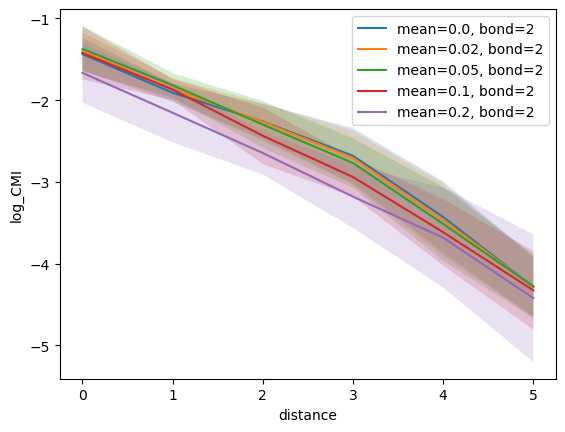

[0.00037251 0.00036222 0.00037625 0.00035479 0.000346   0.00015815]
[0.00016616 0.00015595 0.00015984 0.00013169 0.00014227 0.00011872]
[0.00135513 0.00142443 0.00139771 0.00111172 0.00109105 0.00015599]
[5.75284889e-05 1.23848973e-05 3.37516112e-06 9.53114876e-08
 4.29015265e-08 1.58704765e-09]
[1.92928932e-07 1.82339281e-09 2.97264341e-12 1.07644592e-13
 6.44534137e-17 3.26017600e-20]


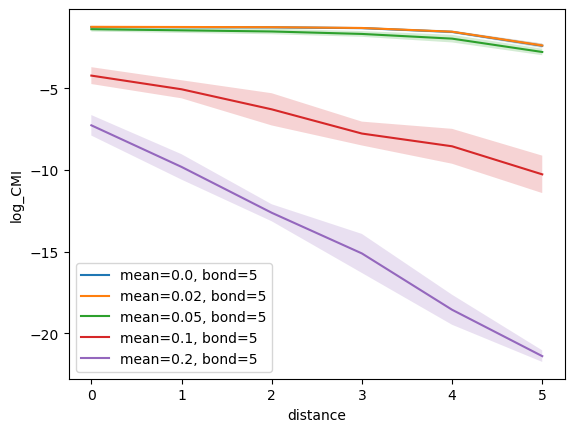

[1.83430479e-05 2.01680994e-05 2.00423114e-05 2.13482092e-05
 1.91162699e-05 8.96447577e-06]
[0.00546235 0.00461554 0.00302162 0.00192891 0.00104671 0.00022922]
[1.31044653e-06 6.39655503e-08 4.28491519e-09 1.25293222e-11
 4.83978462e-14 3.34566618e-15]
[4.61576879e-09 2.19663787e-12 4.83209965e-14 5.34642993e-18
 4.11633899e-22 8.46021211e-24]
[1.86241194e-11 1.82771992e-16 6.81992993e-19 3.51611985e-24]


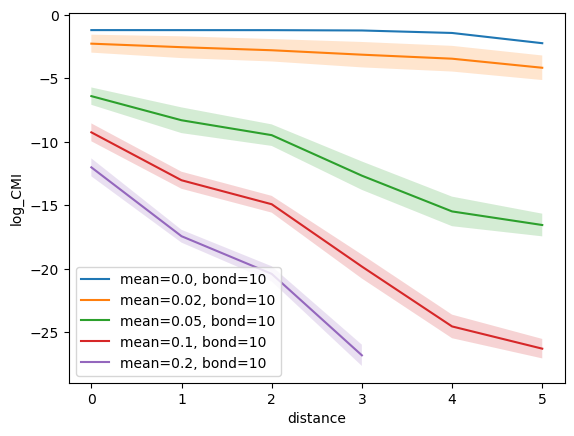

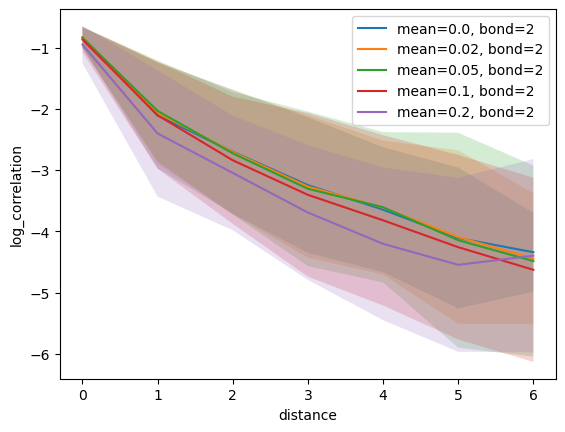

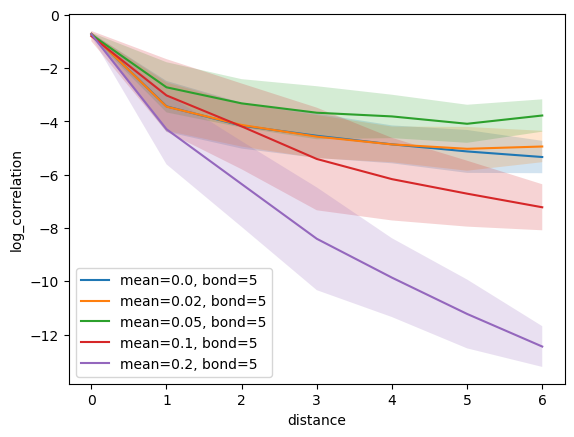

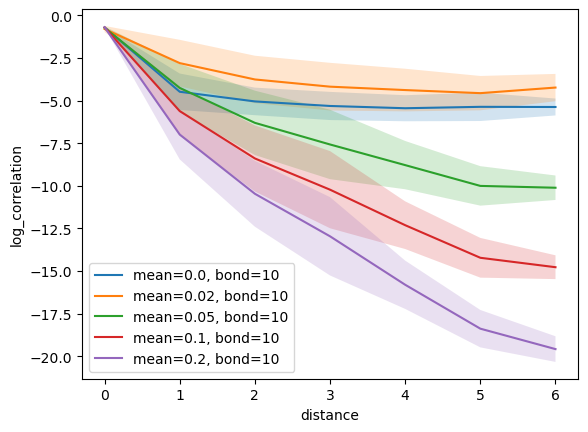

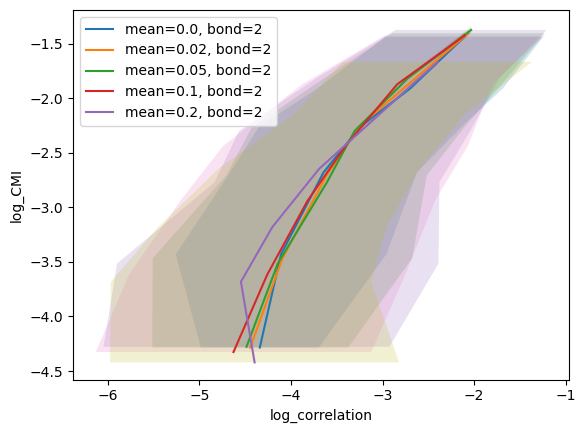

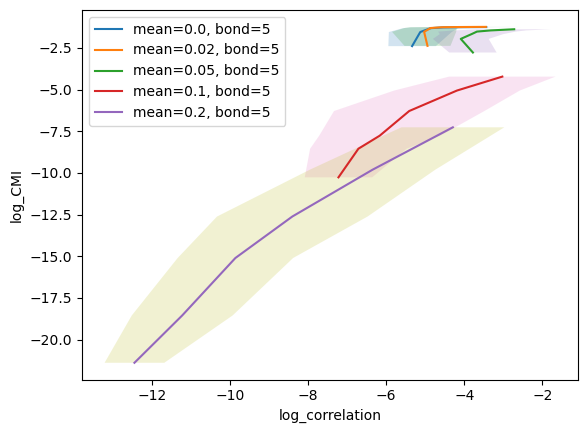

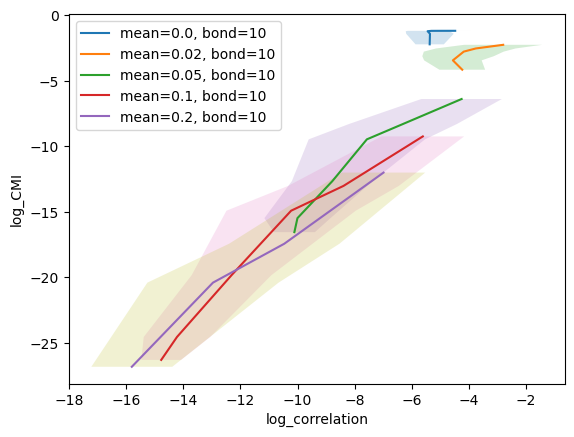

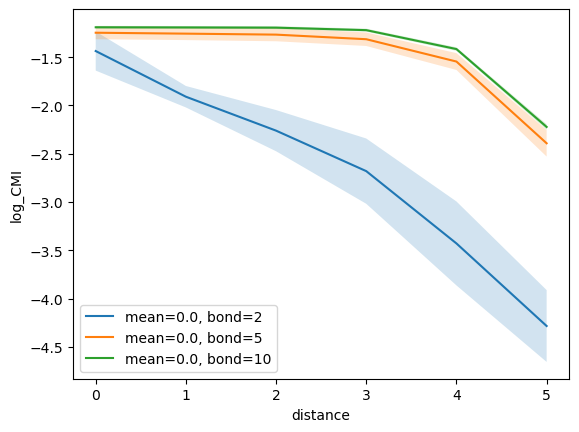

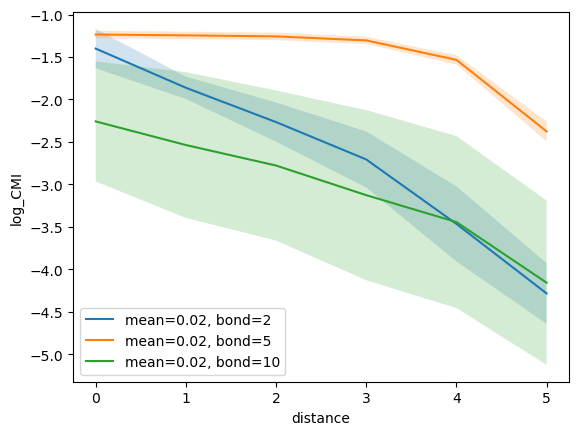

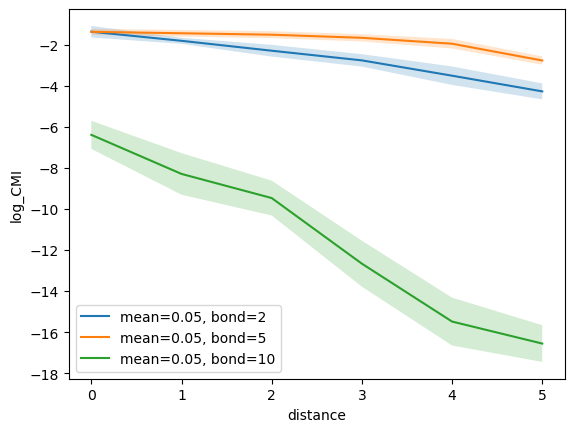

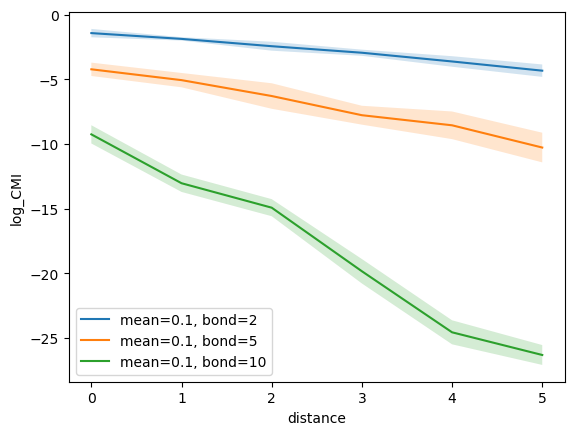

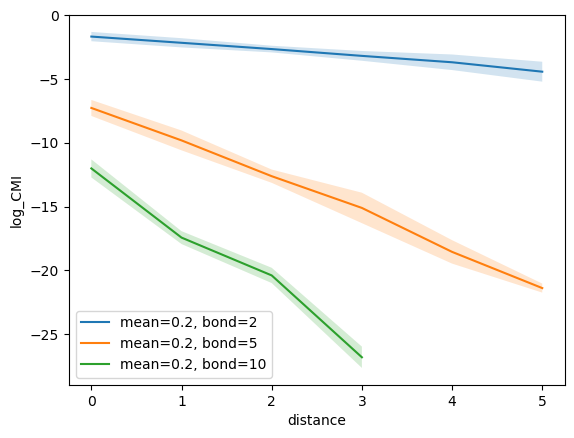

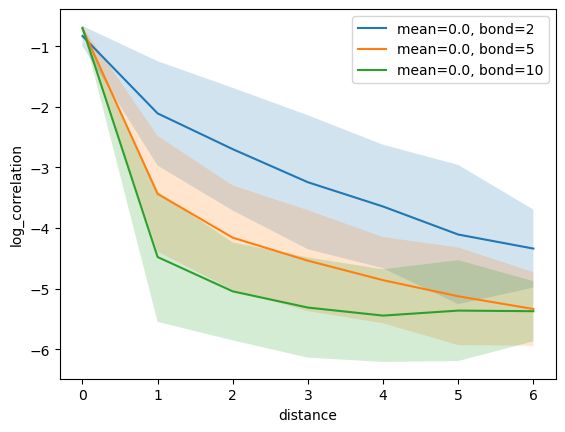

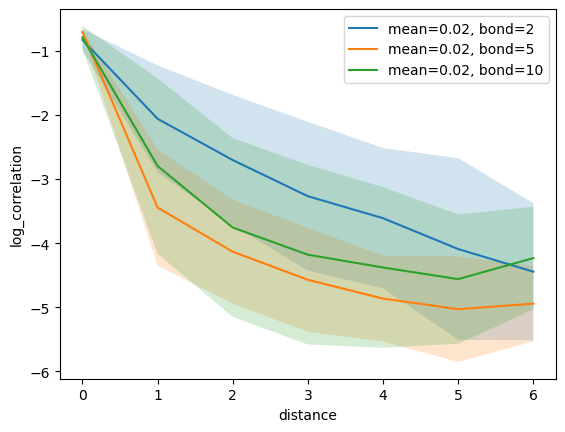

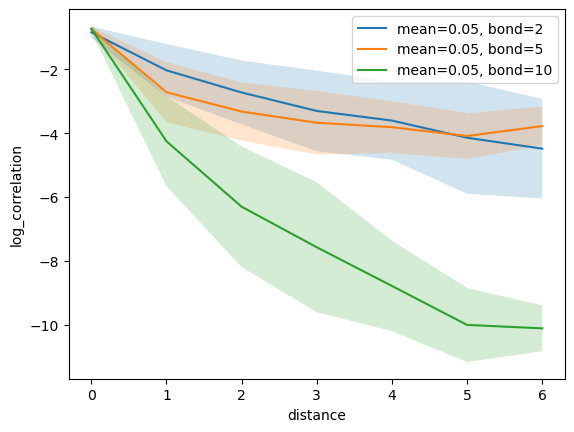

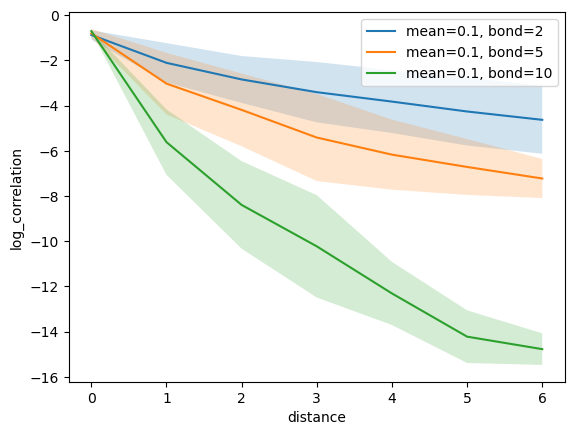

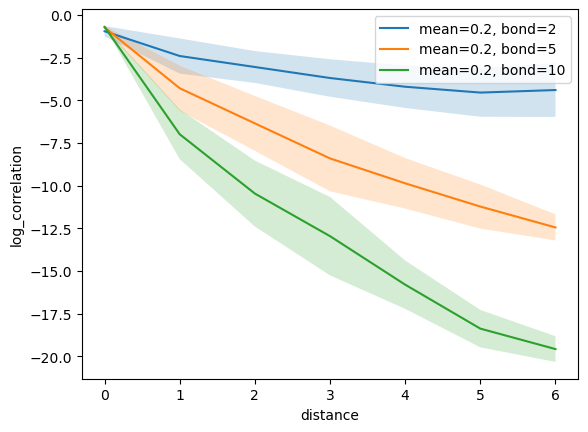

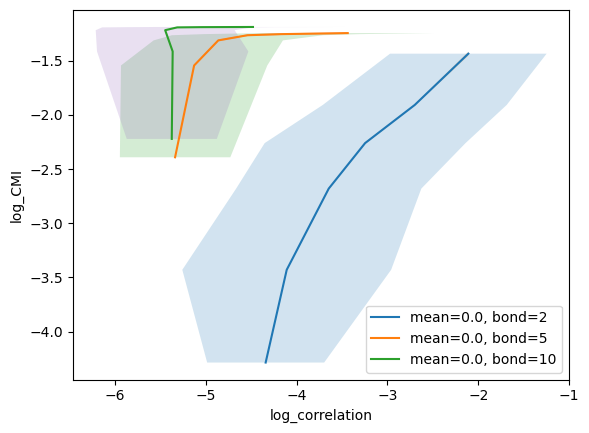

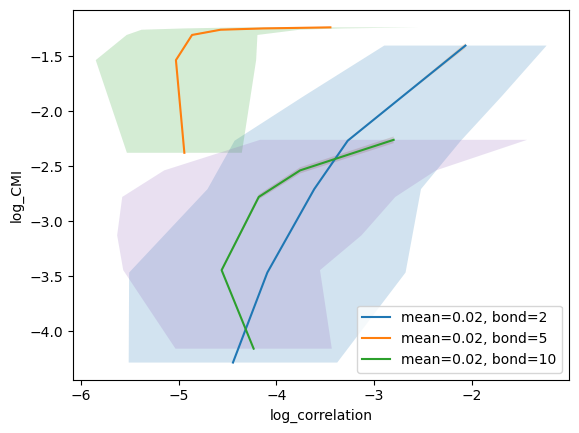

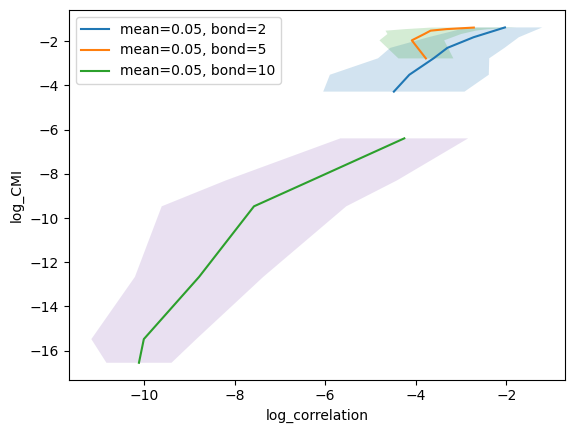

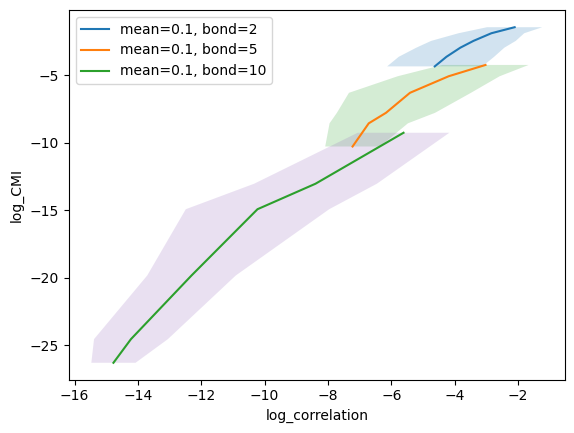

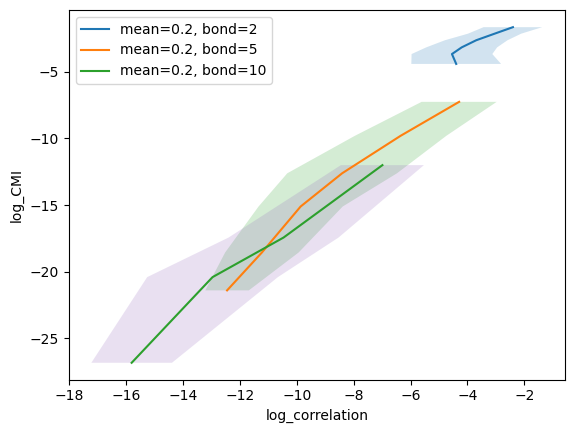

<Figure size 640x480 with 0 Axes>

In [64]:

for j in bond_dim_:
    for i in mean_:
        print(var_cmi[i, j])
        var_cmi[i, j] = var_cmi[i, j][:len(cmi[i, j])][cmi[i, j]>1e-13]
        cmi[i, j] = cmi[i, j][cmi[i, j]>1e-13]
        plt.plot(np.arange(len(cmi[i, j])), np.log(cmi[i, j]), label="mean="+str(i)+", bond="+str(j))
        plt.fill_between(np.arange(len(cmi[i, j])) ,np.log(cmi[i, j]) - 1/(cmi[i, j])*np.sqrt(var_cmi[i, j]) , np.log(cmi[i, j]) + 1/(cmi[i, j])*np.sqrt(var_cmi[i, j]), alpha=0.2)
    plt.xlabel("distance")
    plt.ylabel("log_CMI")
    plt.legend()
    plt.savefig("figure/random_peps/cmi_random_peps_L"+str(L)+"_bond_dim="+str(j)+"_dtype="+str(dtype)+".png")
    plt.show()
    plt.clf()

for j in bond_dim_:
    for i in mean_:
        var_corr[i, j] = var_corr[i, j][mean_corr[i, j]>1e-13]
        mean_corr[i, j] = mean_corr[i, j][mean_corr[i, j]>1e-13]
        plt.plot(np.arange(len(mean_corr[i, j])), np.log(mean_corr[i, j]), label="mean="+str(i)+", bond="+str(j))
        plt.fill_between(np.arange(len(mean_corr[i, j])) ,np.log(mean_corr[i, j]) - 1/mean_corr[i, j]*np.sqrt(var_corr[i, j]) , np.log(mean_corr[i, j]) + 1/mean_corr[i, j]*np.sqrt(var_corr[i, j]), alpha=0.2)
    plt.xlabel("distance")
    plt.ylabel("log_correlation")
    plt.legend()
    plt.savefig("figure/random_peps/correlation_random_peps_L"+str(L)+"_bond_dim="+str(j)+"_dtype="+str(dtype)+".png")
    plt.show()
    plt.clf()

for j in bond_dim_:
    for i in mean_:
        dim = min(len(mean_corr[i, j]), len(cmi[i, j]))
        plt.plot(np.log(mean_corr[i, j][1:dim+1]), np.log(cmi[i, j][:dim]), label="mean="+str(i)+", bond="+str(j))
        plt.fill_betweenx(np.log(cmi[i, j][:dim]), np.log(mean_corr[i, j][1:dim+1]) - 1/mean_corr[i, j][1:dim+1]*np.sqrt(var_corr[i, j][1:dim+1]) , np.log(mean_corr[i, j][1:dim+1]) + 1/mean_corr[i, j][1:dim+1]*np.sqrt(var_corr[i, j][1:dim+1]), alpha=0.2)
        plt.fill_between(np.log(mean_corr[i, j][1:dim+1]), np.log(cmi[i, j][:dim]) - 1/np.sqrt(len(cmi[i, j][:dim]))*np.sqrt(var_cmi[i, j][:dim]) , np.log(cmi[i, j][:dim]) + 1/np.sqrt(len(cmi[i, j][:dim]))*np.sqrt(var_cmi[i, j][:dim]), alpha=0.2)
    plt.xlabel("log_correlation")
    plt.ylabel("log_CMI")
    plt.legend()
    plt.savefig("figure/random_peps/correlation_cmi_random_peps_L"+str(L)+"_bond_dim="+str(j)+"_dtype="+str(dtype)+".png")
    plt.show()
    plt.clf()

for i in mean_:
    for j in bond_dim_:
        plt.plot(np.arange(len(cmi[i, j])), np.log(cmi[i, j]), label="mean="+str(i)+", bond="+str(j))
        plt.fill_between(np.arange(len(cmi[i, j])) ,np.log(cmi[i, j]) - 1/(cmi[i, j])*np.sqrt(var_cmi[i, j]) , np.log(cmi[i, j]) + 1/(cmi[i, j])*np.sqrt(var_cmi[i, j]), alpha=0.2)
    plt.xlabel("distance")
    plt.ylabel("log_CMI")
    plt.legend()
    plt.savefig("figure/random_peps/cmi_random_peps_L"+str(L)+"_mean="+str(i)+"_dtype="+str(dtype)+".png")
    plt.show()
    plt.clf()

for i in mean_:
    for j in bond_dim_:
        plt.plot(np.arange(len(mean_corr[i, j])), np.log(mean_corr[i, j]), label="mean="+str(i)+", bond="+str(j))
        plt.fill_between(np.arange(len(mean_corr[i, j])) ,np.log(mean_corr[i, j]) - 1/mean_corr[i, j]*np.sqrt(var_corr[i, j]) , np.log(mean_corr[i, j]) + 1/mean_corr[i, j]*np.sqrt(var_corr[i, j]), alpha=0.2)
    plt.xlabel("distance")
    plt.ylabel("log_correlation")
    plt.legend()
    plt.savefig("figure/random_peps/correlation_random_peps_L"+str(L)+"_mean="+str(i)+"_dtype="+str(dtype)+".png")
    plt.show()
    plt.clf()

for i in mean_:
    for j in bond_dim_:
        dim = min(len(mean_corr[i, j]), len(cmi[i, j]))
        plt.plot(np.log(mean_corr[i, j][1:dim+1]), np.log(cmi[i, j][:dim]), label="mean="+str(i)+", bond="+str(j))
        plt.fill_betweenx(np.log(cmi[i, j][:dim]), np.log(mean_corr[i, j][1:dim+1]) - 1/mean_corr[i, j][1:dim+1]*np.sqrt(var_corr[i, j][1:dim+1]) , np.log(mean_corr[i, j][1:dim+1]) + 1/mean_corr[i, j][1:dim+1]*np.sqrt(var_corr[i, j][1:dim+1]), alpha=0.2)
        plt.fill_between(np.log(mean_corr[i, j][1:dim+1]), np.log(cmi[i, j][:dim]) - 1/np.sqrt(len(cmi[i, j][:dim]))*np.sqrt(var_cmi[i, j][:dim]) , np.log(cmi[i, j][:dim]) + 1/np.sqrt(len(cmi[i, j][:dim]))*np.sqrt(var_cmi[i, j][:dim]), alpha=0.2)
    plt.xlabel("log_correlation")
    plt.ylabel("log_CMI")
    plt.legend()
    plt.savefig("figure/random_peps/correlation_cmi_random_peps_L"+str(L)+"_mean="+str(i)+"_dtype="+str(dtype)+".png")
    plt.show()
    plt.clf()

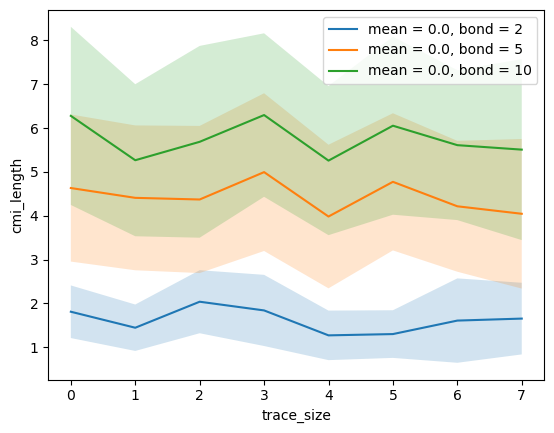

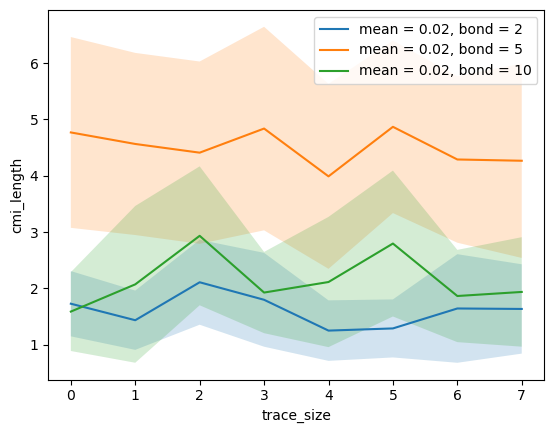

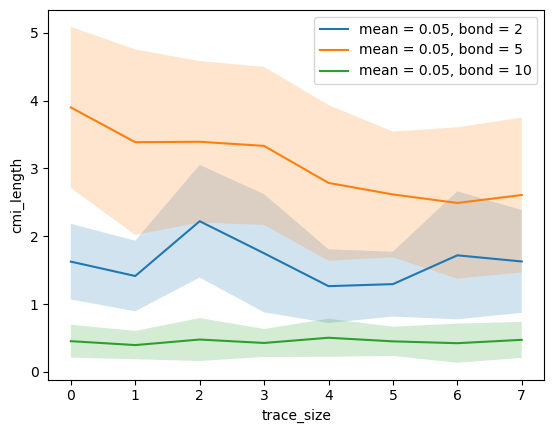

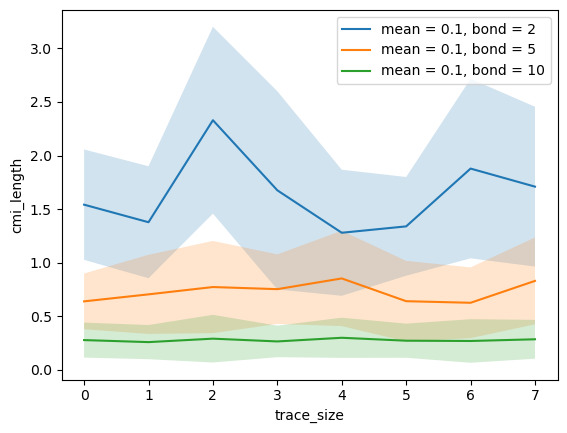

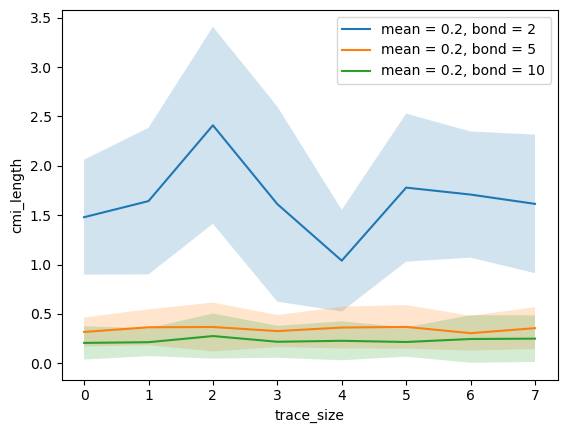

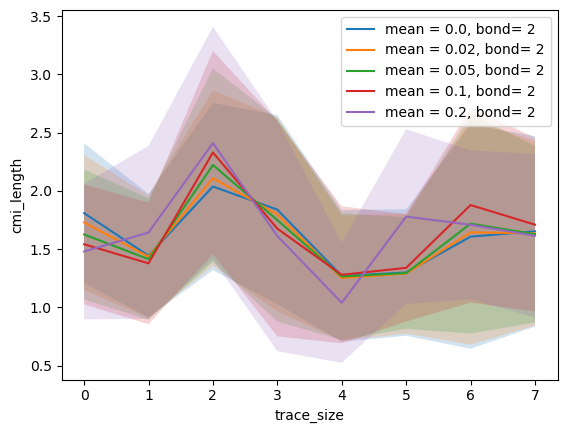

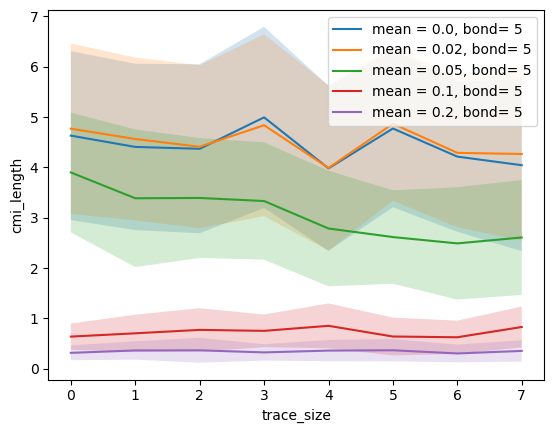

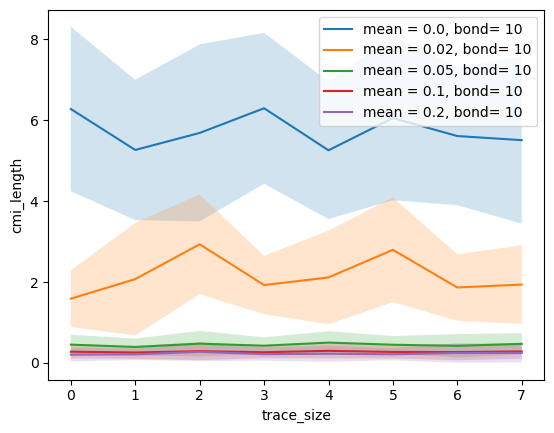

<Figure size 640x480 with 0 Axes>

In [121]:

for i in range(len(mean_)):
    for j in range(len(bond_dim_)):
        plt.plot(np.arange(len(cmi_length_traceout[i][j])), cmi_length_traceout[i][j], label="mean = "+str(mean_[i]) + ", bond = "+str(bond_dim_[j]))
        plt.fill_between(np.arange(len(cmi_length_traceout[i][j])), cmi_length_traceout[i][j] - np.sqrt(var_cmi_length_traceout[i][j]) , cmi_length_traceout[i][j] + np.sqrt(var_cmi_length_traceout[i][j]), alpha=0.2)
    plt.xlabel("trace_size")
    plt.ylabel("cmi_length")
    plt.legend()
    plt.savefig("figure/random_peps/traceout/cmi_length_traceout_random_peps_L"+str(L)+"mean="+str(i)+"dtype="+str(dtype)+".png")
    plt.show()
    plt.clf()

for j in range(len(bond_dim_)):
    for i in range(len(mean_)):
        plt.plot(np.arange(len(cmi_length_traceout[i][j])), cmi_length_traceout[i][j], label= "mean = "+str(mean_[i])+", bond= "+str(bond_dim_[j]))
        plt.fill_between(np.arange(len(cmi_length_traceout[i][j])), cmi_length_traceout[i][j] - np.sqrt(var_cmi_length_traceout[i][j]) , cmi_length_traceout[i][j] + np.sqrt(var_cmi_length_traceout[i][j]), alpha=0.2)
    plt.xlabel("trace_size")
    plt.ylabel("cmi_length")
    plt.legend()
    plt.savefig("figure/random_peps/traceout/cmi_length_traceout_random_peps_L"+str(L)+"_bond_dim="+str(j)+"dtype="+str(dtype)+".png")
    plt.show()
    plt.clf()